# Predicting Stock Prices with Technical Indicators

#### New Technical terms 

1) Simple Moving Average (SMA):
The SMA is one of the most fundamental indicators. It takes the `average` of a stock's closing price over a specific number of days. In our code, we're using a 10-day SMA and a 50-day SMA.
    - *Why is it useful?* The SMA helps to smooth out price data, making it easier to see the overall trend. A short-term SMA (like the 10-day) reacts quickly to price changes, while a long-term SMA (like the 50-day) is much slower and shows the bigger picture. When a short-term SMA crosses above a long-term SMA, it's often seen as a bullish signal (a sign of a rising trend), and a cross below is a bearish signal (a sign of a falling trend). By including these as features, our model can learn these trend-following patterns.
2) Relative Strength Index (RSI):
The RSI is a momentum indicator. It measures the `speed and magnitude` of recent price changes to evaluate overbought or oversold conditions in the price of a stock. The RSI is displayed as an **oscillator**, a line graph that moves between two extremes, and is typically a value from 0 to 100.
    - Why is it useful? A high RSI (typically above 70) suggests that the stock is overbought, meaning its price has risen too quickly and might be due for a correction. A low RSI (typically below 30) suggests the stock is oversold, meaning its price has fallen too quickly and might be due for a bounce back. By feeding the RSI into our model, we're giving it information about the "mood" or momentum of the market, which can be a strong predictor of short-term price movements.[source](https://www.oanda.com/us-en/trade-tap-blog/trading-knowledge/understanding-the-relative-strength-index/#:~:text=What%20is%20the%20Relative%20Strength,Technical%20Trading%20Systems%20in%201978.)
    - How it helps our model: By including the RSI as a feature, we're giving our model a powerful piece of information about market psychology. The model can learn that when a stock enters "overbought" territory (e.g., RSI > 70), there's a higher probability of a price decrease in the near future. Conversely, an "oversold" signal (RSI < 30) could suggest a potential buying opportunity.
3) Moving Average Convergence Divergence (MACD) : MACD offers a visual representation of the ups and downs in price action as influenced by market volatility. It is a powerful and widely used momentum indicator in financial analysis. It's designed to help identify the strength, direction, momentum, and duration of a stock's trend. Unlike the Simple Moving Average (SMA) which shows a simple average of prices, the MACD provides a more `dynamic view of the relationship between two different moving averages`. It's essentially a tool for spotting changes in momentum.



In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_63631/2510862578.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2018-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed


Downloaded data for: GOOG
Price           Close       High        Low       Open    Volume
Ticker           GOOG       GOOG       GOOG       GOOG      GOOG
Date                                                            
2018-01-02  52.935341  53.031768  51.952683  52.107263  24752000
2018-01-03  53.804180  53.993553  52.846373  52.901048  28604000
2018-01-04  53.999023  54.355406  53.879832  54.078553  20092000
2018-01-05  54.785843  54.886248  54.277364  54.376775  25582000
2018-01-08  55.019955  55.235175  54.755528  54.785846  20952000
length of X: 1459
Random Forest MSE: 8.972117778425051
SVR MSE: 5.671630447918513


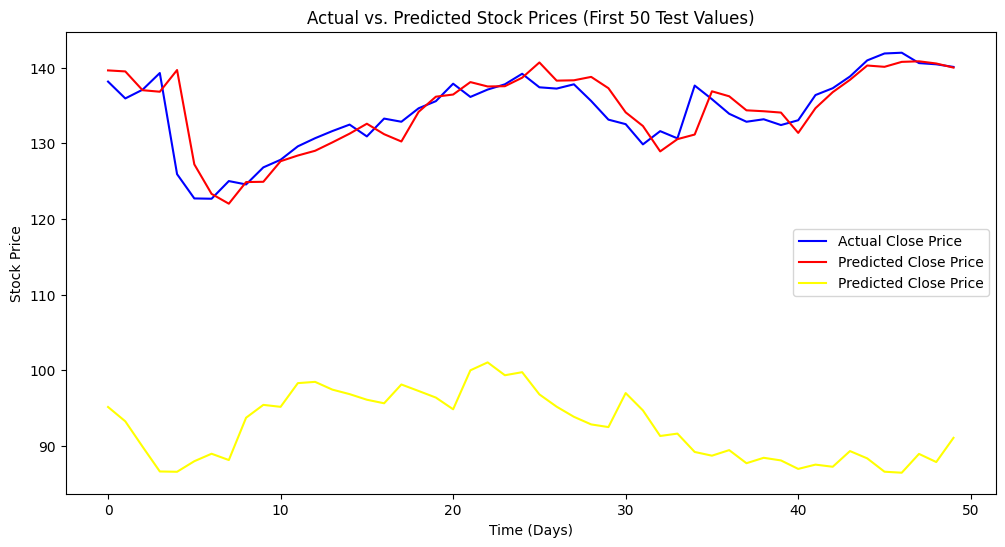

In [59]:
# Creating Advance technical features
#Fetch the stock data 
ticker = 'GOOG'
data = yf.download(ticker, start='2018-01-01', end='2024-01-01')
print("Downloaded data for:", ticker)
print(data.head())

# 2) Relative Strength Index (RSI):
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain/loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 1) Simple Moving Average (SMA): low and medium term
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['RSI_14'] = compute_rsi(data)

# Prepare the data
data['Next Close'] = data['Close'].shift(-1)

data = data.dropna()

X = data[['Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_50', 'RSI_14']]
y = data['Next Close']

print("length of X:", len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Feature Scaling for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest MSE: {mse_rf}')

# Model 2: Support Vector Regressor (SVR)
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f'SVR MSE: {mse_svr}')

# Visualizing the results for the second model
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[-50:], label='Actual Close Price', color='blue')
plt.plot(y_pred_rf[-50:], label='Predicted Close Price', color='red')
plt.plot(y_pred_svr[:50], label='Predicted Close Price', color='yellow')
plt.title('Actual vs. Predicted Stock Prices (First 50 Test Values)')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()